In [1]:
import random
import sys
import os
import json
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F

from glob import glob
from typing import List, Mapping, Tuple, Optional, Any
from collections import OrderedDict
from tqdm.notebook import tqdm
from torch.nn.modules.loss import _WeightedLoss
from catalyst import dl
from catalyst.dl import utils
from catalyst.dl import SupervisedRunner
from catalyst.contrib.nn.optimizers import RAdam, Lookahead, Adam
from catalyst.dl.callbacks import OptimizerCallback, EarlyStoppingCallback, SchedulerCallback, CriterionCallback, CheckpointCallback
from ranger_adabelief import RangerAdaBelief 
from adabelief_pytorch import AdaBelief

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
from matplotlib import pyplot as plt

from basic_utils.data import slice_sequances, anton_slicer
from basic_utils.metric import map_per_set, map_per_image, mean_average_precision_at_k, average_precision_at_k
from nn_utils.swa import avarage_weights
from nn_utils.callbacks import MAP5Callback, CinemaMAP5Callback

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'
print(f'Cur device : {DEVICE}')

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.manual_seed(seed_value)    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(1234)

Cur device : cuda


In [3]:
BS = 2048
SEQ_LEN = 100
EXP_NAME = 'cnnbigkernel_antonseqs_2048bs_100seqlen_adam_byCMAP_fixedagainmetric_correctstretifiedval'

## Load data

In [4]:
movies_ts = pd.read_csv('/ssd_data/cinema_hack/movies_dataset_10 months.csv')
movies_ts['ts'] = pd.to_datetime(movies_ts['ts'])
movies_ts = movies_ts.sort_values('ts').reset_index(drop=True)

In [5]:
sample_submission = pd.read_csv('/ssd_data/cinema_hack/submission.csv')

sample_submission['movie_id'] = sample_submission[' movie_id']
sample_submission = sample_submission.drop(columns=' movie_id')

In [6]:
with open("../add_data/ActorEmbed.json", "r") as read_file:
    actor_emb = json.load(read_file)
    actor_emb = {int(k):torch.Tensor(v) for k,v in actor_emb.items()}
    
with open("../add_data/DirectorEmbed.json", "r") as read_file:
    director_emb = json.load(read_file)
    director_emb = {int(k):torch.Tensor(v) for k,v in director_emb.items()}
    
with open("../add_data/GenreEmbed.json", "r") as read_file:
    genre_emb = json.load(read_file)
    genre_emb = {int(k):torch.Tensor(v) for k,v in genre_emb.items()}

In [7]:
missed_movies = set(movies_ts['movie_id']) - set(list(map(int, actor_emb.keys())))
for el in missed_movies:
    actor_emb[el] = torch.zeros_like(actor_emb[1])
    director_emb[el] = torch.zeros_like(director_emb[1])
    genre_emb[el] = torch.zeros_like(genre_emb[1])

## Prepare data

In [8]:
le_film_id = preprocessing.LabelEncoder()

# Increase train index for zero padding
movies_ts['movie_id'] = le_film_id.fit_transform(movies_ts['movie_id']) + 1

sequences = movies_ts.groupby('user_id')['movie_id'].apply(list)
sequences2use = sequences[sequences.apply(len) >= 10]

le_classes = le_film_id.classes_

In [9]:
GENRE_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, genre_emb[0].shape[0]))
DIRECTOR_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, director_emb[0].shape[0]))
ACTOR_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, actor_emb[0].shape[0]))

In [10]:
for i in range(le_classes.shape[0]):
    GENRE_EMB[i+1] = genre_emb[le_classes[i]]
    DIRECTOR_EMB[i+1] = director_emb[le_classes[i]]
    ACTOR_EMB[i+1] = actor_emb[le_classes[i]]

In [11]:
maxlen = SEQ_LEN # Length of sequences in X
X = []
y = []

def slice_sequence(seq, num_slices):
    for i in range(1, num_slices):
        X.append(seq[-(i+maxlen+4): -(i+4)])
        if i == 1:
            y.append(seq[-(i+4):])
        else:
            y.append(seq[-(i+4):-(i-1)])
        
for seq in sequences2use:
    if len(seq) <= 5+5:
        slice_sequence(seq, 2)
    elif len(seq) <= 6+5:
        slice_sequence(seq, 3)
    elif len(seq) <= 8+5:
        slice_sequence(seq, 4)
    elif len(seq) <= 12+5:
        slice_sequence(seq, 6)
    elif len(seq) <= 16+5:
        slice_sequence(seq, 8)
    elif len(seq) <= 20+5:
        slice_sequence(seq, 11)
    elif len(seq) <= 26+5:
        slice_sequence(seq, 16)
    else:
        slice_sequence(seq, 23)

In [12]:
print(len(X), len(y))
print()
lens = [len(x) for x in X]
print(max(lens), min(lens), np.mean(lens), np.median(lens))

43774 43774

100 5 81.6991593183168 100.0


(array([  911.,  1604.,  2050.,  1907.,  1995.,  1724.,  2006.,  1824.,
         1880., 27873.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <BarContainer object of 10 artists>)

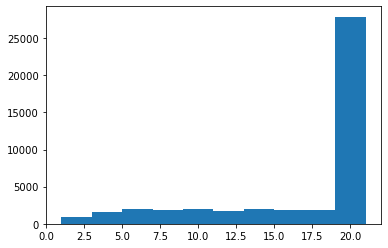

In [13]:
lens_discrit = np.digitize(lens, np.histogram(lens, bins=20)[1])
plt.hist(lens_discrit)

In [14]:
for i in range(len(X)):
    X[i] = [0]*(maxlen - len(X[i])) + X[i]

In [15]:
sequences_test = sequences.apply(lambda x: x[-maxlen:])
sequences_test = sequences_test.apply(lambda x: [0 for i in range(maxlen - len(x))] + x)

test_users_in_sequences = sorted(set(sequences_test.index) & set(sample_submission.user_id))

X_test = np.array(sequences_test[test_users_in_sequences].tolist())

In [16]:
X = np.array(X)
# Decrease target index 
y = np.array(y) - 1

In [17]:
X.shape, y.shape

((43774, 100), (43774, 5))

In [18]:
len(lens_discrit)

43774

## Train

In [19]:
class CinemaCE(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, input, target):
        return self.loss(input, target[:,0])

In [20]:
class Conv1dStack(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, padding=1, dilation=1):
        super(Conv1dStack, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_dim, out_dim, kernel_size=kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm1d(out_dim),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
        )
        self.res = nn.Sequential(
            nn.Conv1d(out_dim, out_dim, kernel_size=kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm1d(out_dim),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        x = self.conv(x)
        h = self.res(x)
        return x + h

class BaselineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddding = nn.Embedding(4843+1, 64, padding_idx=0)
#         self.actor_layer = nn.Embedding(ACTOR_EMB.shape[0], ACTOR_EMB.shape[1], _weight=ACTOR_EMB)
#         self.actor_layer.weight.requires_grad = False
#         self.director_layer = nn.Embedding(DIRECTOR_EMB.shape[0], DIRECTOR_EMB.shape[1], _weight=DIRECTOR_EMB)
#         self.director_layer.weight.requires_grad = False
#         self.genre_layer = nn.Embedding(GENRE_EMB.shape[0], GENRE_EMB.shape[1], _weight=GENRE_EMB)
#         self.genre_layer.weight.requires_grad = False
        
        self.emb_dropout = nn.Dropout(0.01)

        self.cnns = nn.Sequential(
            nn.Conv1d(64, 256, kernel_size=31),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            
            nn.Conv1d(256, 128, kernel_size=13),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            
            nn.Conv1d(128, 128, kernel_size=7),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(128, 4843)
        )
       
    def forward(self, x):
#         x = torch.cat([
#             self.embeddding(x), self.actor_layer(x), self.director_layer(x), self.genre_layer(x)
#         ], dim=-1)
        x = self.embeddding(x)
        x = x.permute(0,2,1)
        x = self.cnns(x)
        out = self.fc(x.mean(-1))
        return out

In [21]:
def train_function(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    exp_name: str = EXP_NAME
):
    print(f"Train shapes: {X_train.shape, y_train.shape}")
    print(f"Test shapes: {X_val.shape, y_val.shape}")
    dataset_train = torch.utils.data.TensorDataset(
        X_train,
        y_train
    )
    dataloader_train = torch.utils.data.DataLoader(dataset_train, BS, shuffle=True, drop_last=True)

    dataset_val = torch.utils.data.TensorDataset(
        X_val,
        y_val
    )
    dataloader_val = torch.utils.data.DataLoader(dataset_val, BS)

    loaders = {'train':dataloader_train, 'valid': dataloader_val}
   
    model = BaselineModel().to(DEVICE)
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min')

    criterion =  CinemaCE()#nn.CrossEntropyLoss()

    callbacks =[
                CinemaMAP5Callback(),
                OptimizerCallback(metric_key="loss", accumulation_steps=1),
                EarlyStoppingCallback(patience=10, metric='CMAP5', minimize=False),
                SchedulerCallback(mode='epoch', reduced_metric="loss"),
                CheckpointCallback(save_n_best=3)
            ]

    runner = SupervisedRunner()

    # Train 
    runner.train(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            loaders=loaders,
            logdir=exp_name,
            num_epochs=999,
            verbose=True,
            main_metric="CMAP5",
            minimize_metric=False,
            callbacks=callbacks
        ) 
    
def inference_function(
    X_array: torch.Tensor,
    exp_name: str,
    return_logits: bool = False
):
    dataset = torch.utils.data.TensorDataset(
        X_array,
        torch.zeros_like(X_array)
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BS)
    
    runner = SupervisedRunner()
    prediction = runner.predict_loader(
        loader=dataloader, 
        model=BaselineModel().to(DEVICE), 
        resume=f'{exp_name}/checkpoints/best.pth'
    )
    prediction = torch.cat([b['logits'].detach().cpu() for b in prediction])
    if return_logits:
        prediction = prediction.numpy()
    else:
        prediction = torch.sort(-prediction, 1).indices[:,:5].numpy()
    
    return prediction

Fold 0 started of 1234


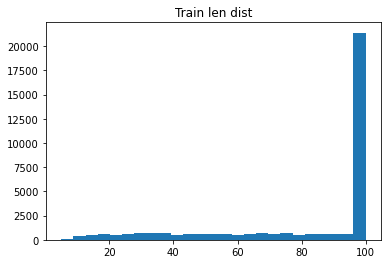

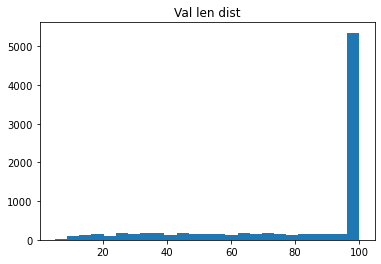

SWA score: [6.141018894561558, 6.141392605267955, 6.1416163986985985]
SWA
Best score: 0.07149286122215982
Fold 1 started of 1234


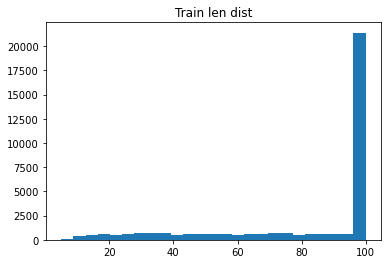

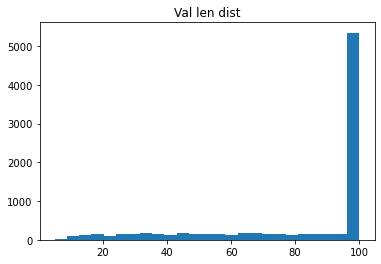

SWA score: [6.154898901165451, 6.154949110075789, 6.155023397819305]
SWA
Best score: 0.0679565962307258
Fold 2 started of 1234


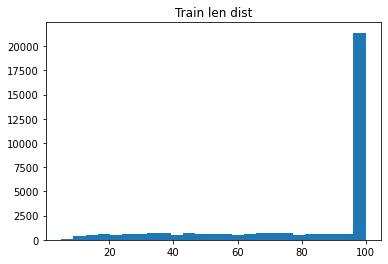

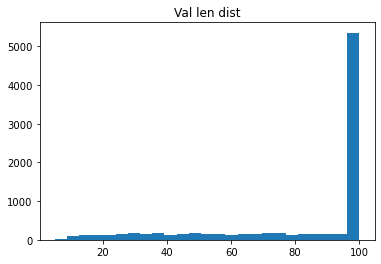

SWA score: [6.062669531540623, 6.062968313673576, 6.06349179721573]
SWA
Best score: 0.07283723586522077
Fold 3 started of 1234


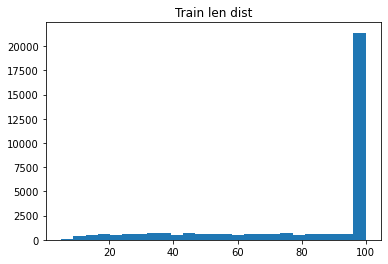

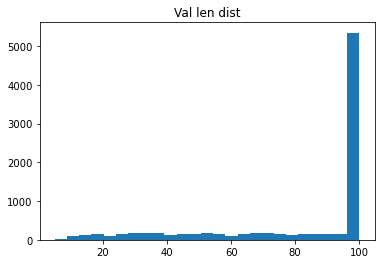

SWA score: [6.138464756327857, 6.139241423952723, 6.139809262010454]
SWA
Best score: 0.06818694079573633
Fold 4 started of 1234


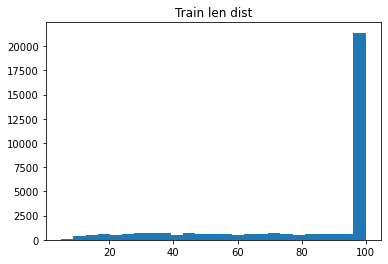

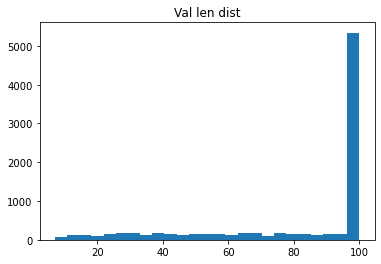

SWA score: [6.057205680409659, 6.057207877869636, 6.057487956459511]
SWA
Best score: 0.07134528977229543
Fold 0 started of 1


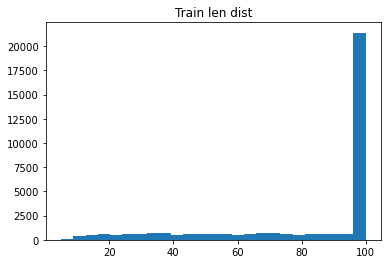

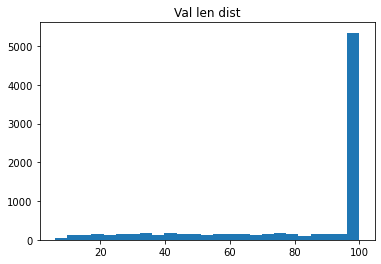

SWA score: [6.133078231789738, 6.133302764032038, 6.133908308171872]
SWA
Best score: 0.0647329145250336
Fold 1 started of 1


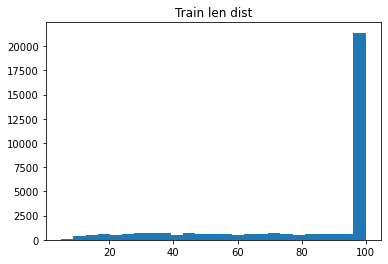

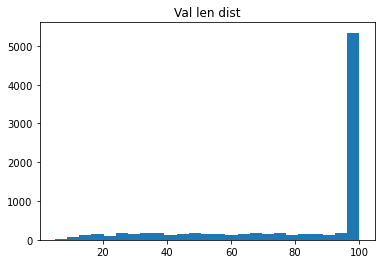

SWA score: [6.0904974486472465, 6.090513501420557, 6.091774628790088]
SWA
Best score: 0.06819531696173686
Fold 2 started of 1


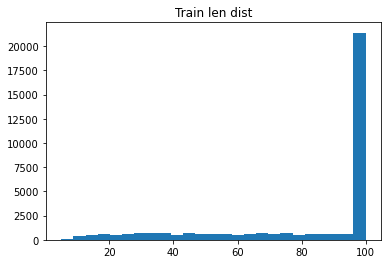

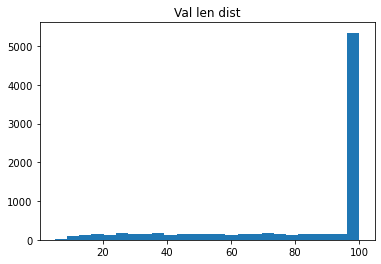

SWA score: [6.041263888537169, 6.041468010624091, 6.04152374469097]
SWA
Best score: 0.06891871311631527
Fold 3 started of 1


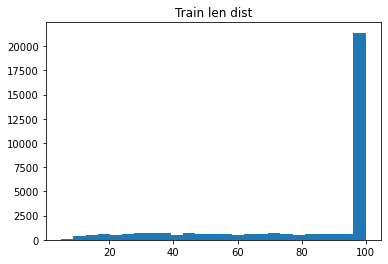

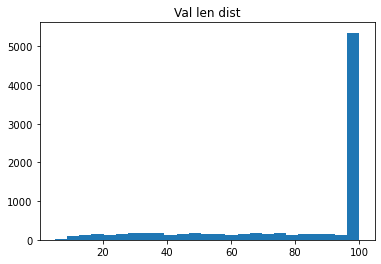

SWA score: [6.049039327860014, 6.049229116183836, 6.04974320431834]
SWA
Best score: 0.06996116504854447
Fold 4 started of 1


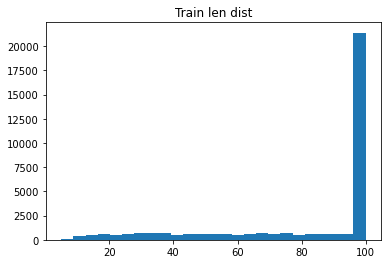

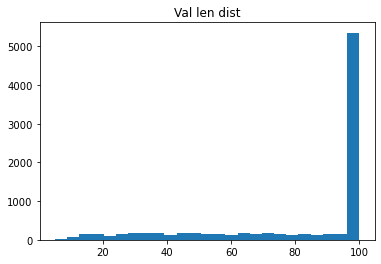

SWA score: [6.1278832306839, 6.129873648663756, 6.129943404373089]
SWA
Best score: 0.07135023989033686
Fold 0 started of 2


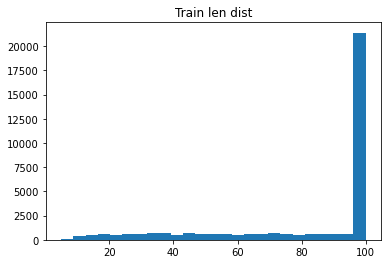

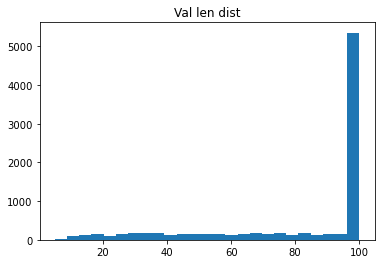

SWA score: [6.142884422424246, 6.1434095418092385, 6.143830902735755]
SWA
Best score: 0.07195012373881714
Fold 1 started of 2


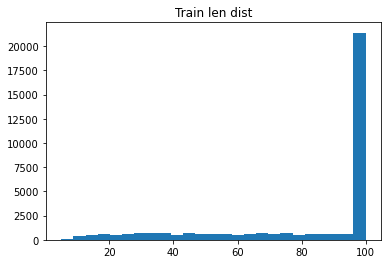

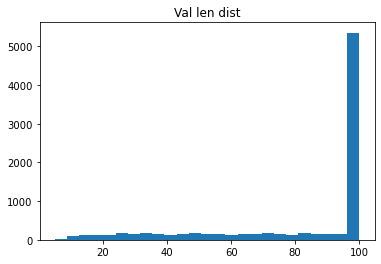

SWA score: [6.080724292179982, 6.080831091503359, 6.081012500292366]
SWA
Best score: 0.0689137635636787
Fold 2 started of 2


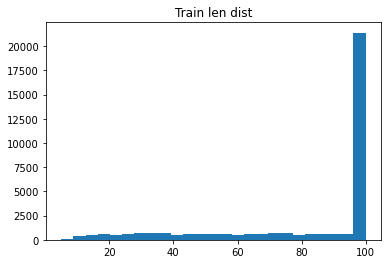

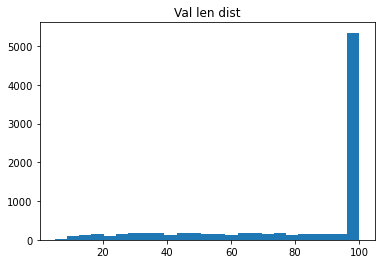

SWA score: [6.08174348936838, 6.082309226510458, 6.083124196059631]
SWA
Best score: 0.06852769845802467
Fold 3 started of 2


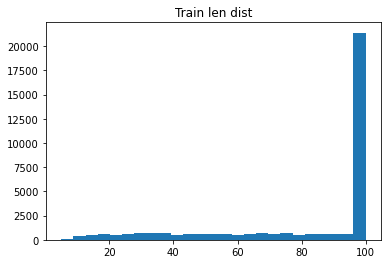

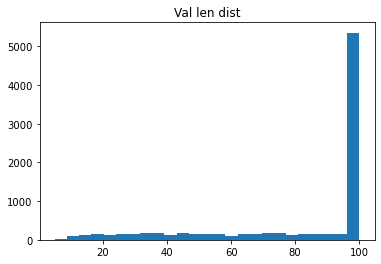

SWA score: [6.10050842284067, 6.100611175447788, 6.100882907815146]
SWA
Best score: 0.06901465829050141
Fold 4 started of 2


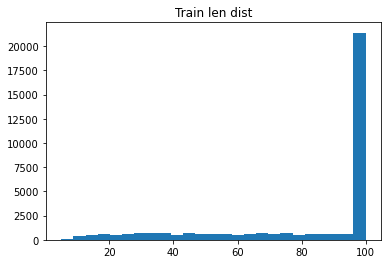

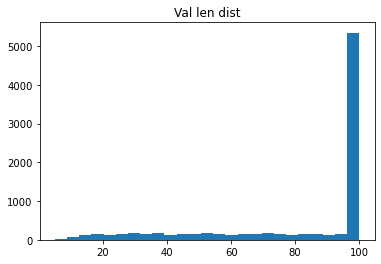

SWA score: [6.089063765007474, 6.089112993187629, 6.089689783345136]
SWA
Best score: 0.06946805269971915
Fold 0 started of 3


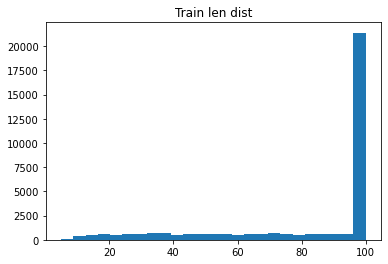

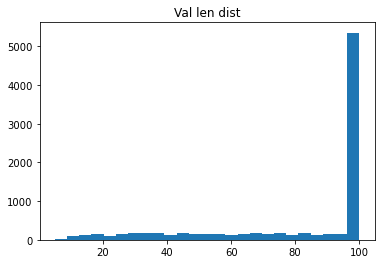

SWA score: [6.0886080593738745, 6.088744353104291, 6.088824872246202]
SWA
Best score: 0.06902836474395642
Fold 1 started of 3


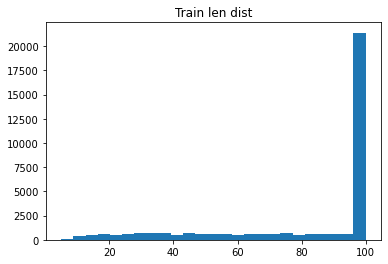

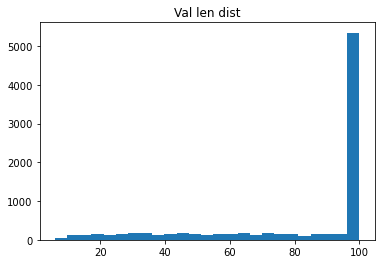

SWA score: [6.091711572726613, 6.094374321938106, 6.095081540886025]
SWA
Best score: 0.0660308395202749
Fold 2 started of 3


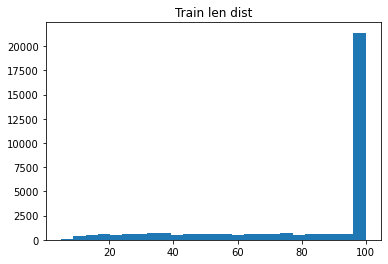

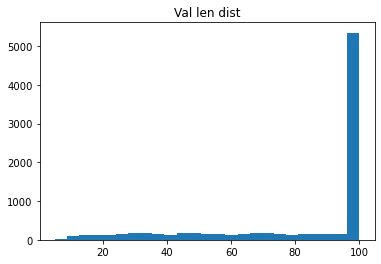

SWA score: [6.073937673421671, 6.074173826602171, 6.074270814789968]
SWA
Best score: 0.06532876451551539
Fold 3 started of 3


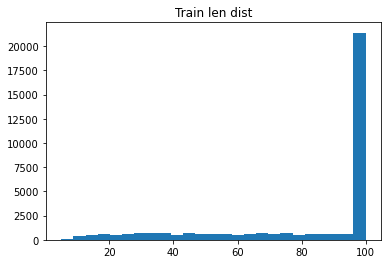

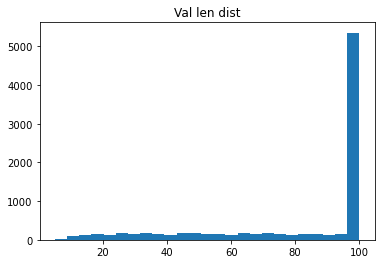

SWA score: [6.061620690657846, 6.061854308077705, 6.062366046284621]
SWA
Best score: 0.06845650104702138
Fold 4 started of 3


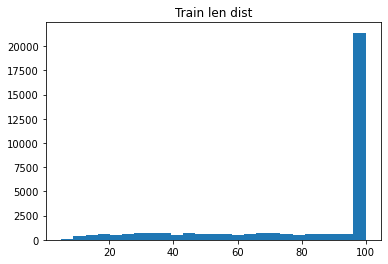

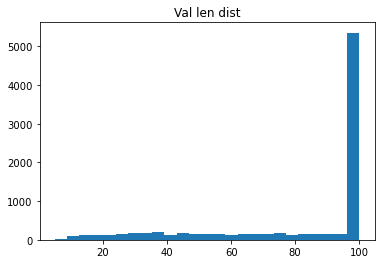

SWA score: [6.119166416584806, 6.119561570459287, 6.119907595508306]
SWA
Best score: 0.07112748457847941
Fold 0 started of 4


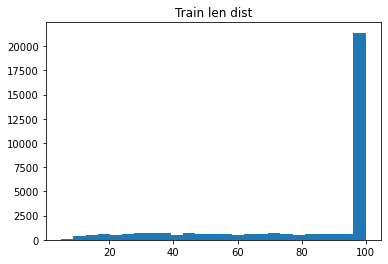

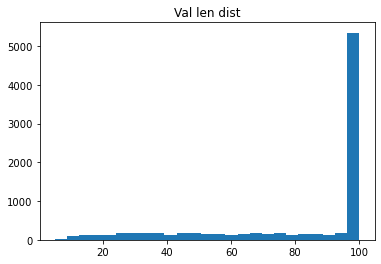

SWA score: [6.139419129370009, 6.1407409323752775, 6.140879430830785]
SWA
Best score: 0.07224214734437583
Fold 1 started of 4


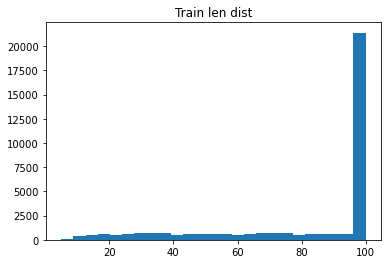

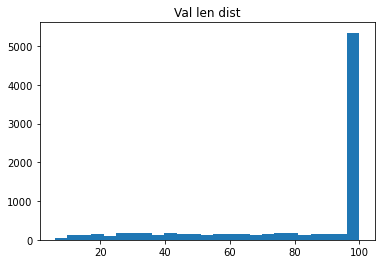

SWA score: [6.091709370779215, 6.092090856028175, 6.0925648425661585]
SWA
Best score: 0.06893394250904349
Fold 2 started of 4


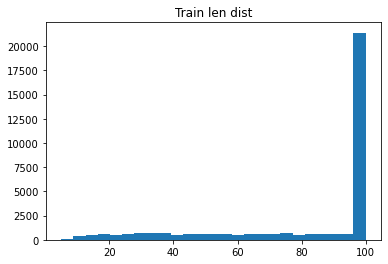

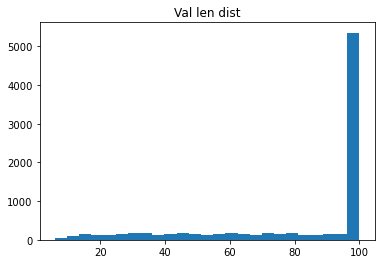

SWA score: [6.105497374226882, 6.105581071756691, 6.105874484556188]
SWA
Best score: 0.06834189986674338
Fold 3 started of 4


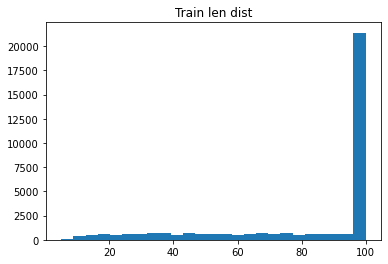

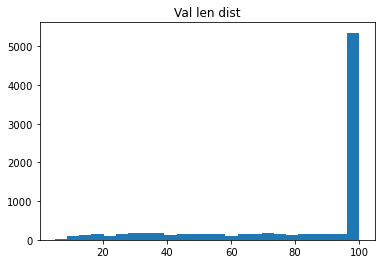

SWA score: [6.038088728808322, 6.03857349197501, 6.038573708526071]
SWA
Best score: 0.069850751951267
Fold 4 started of 4


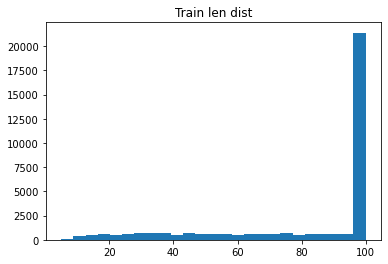

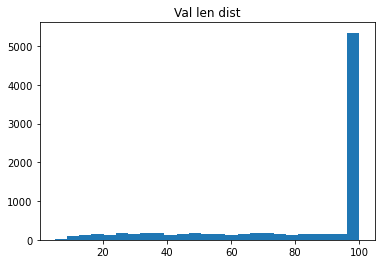

SWA score: [6.124492587851476, 6.124878642600994, 6.125315226946406]
SWA
Best score: 0.07122610616099383
Fold 0 started of 5


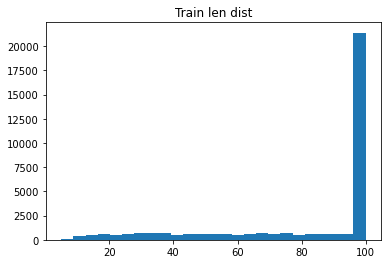

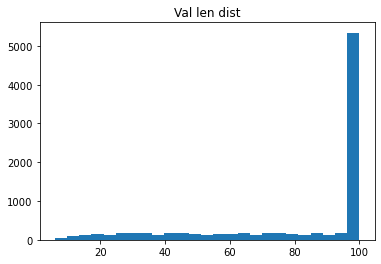

SWA score: [6.075090943058173, 6.0754519296468565, 6.075623434438221]
SWA
Best score: 0.06727508090614957
Fold 1 started of 5


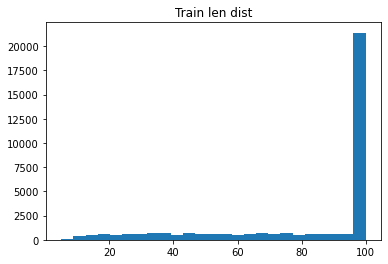

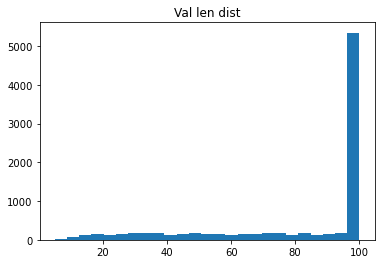

SWA score: [6.000524519349016, 6.000777232313347, 6.0011338806370205]
SWA
Best score: 0.06889967637540516
Fold 2 started of 5


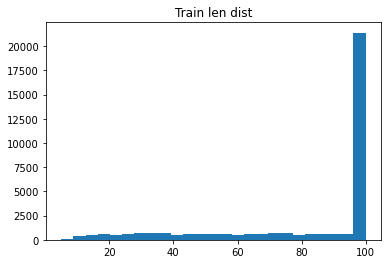

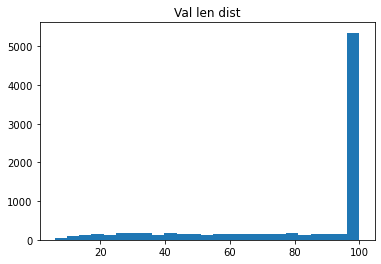

SWA score: [6.184725829875517, 6.184804083891149, 6.1848485977700065]
SWA
Best score: 0.07126708547496773
Fold 3 started of 5


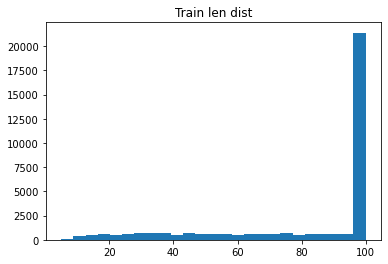

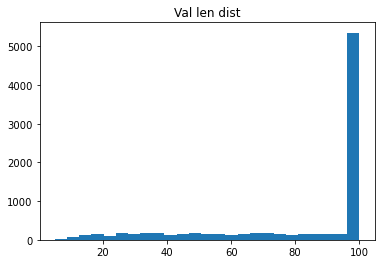

SWA score: [6.071454231974603, 6.071973143598817, 6.07237883311282]
SWA
Best score: 0.06652922139729736
Fold 4 started of 5


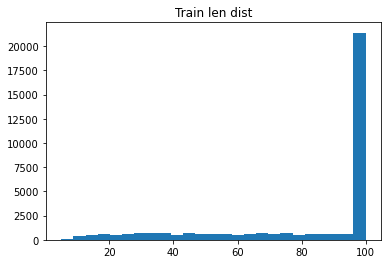

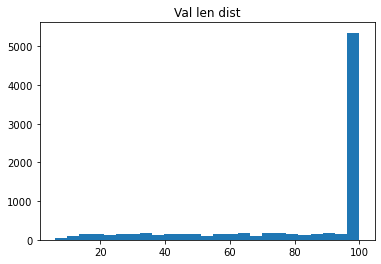

SWA score: [6.185655396687867, 6.185975124663296, 6.186200996444246]
SWA
Best score: 0.07175729190465423
Fold 0 started of 6


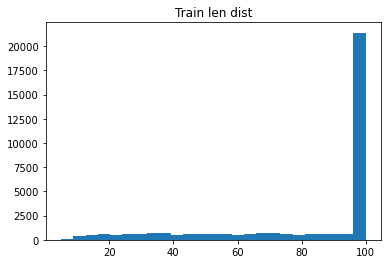

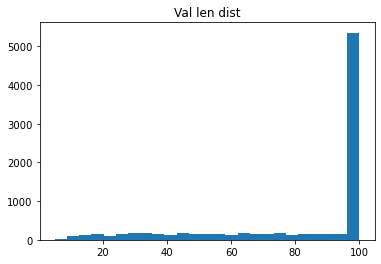

SWA score: [6.108634592913546, 6.108875060285724, 6.109037553807928]
SWA
Best score: 0.0726145059965746
Fold 1 started of 6


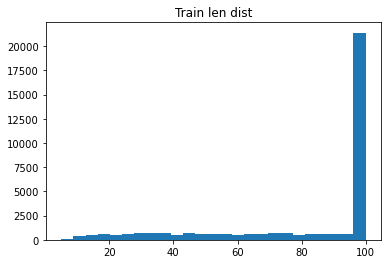

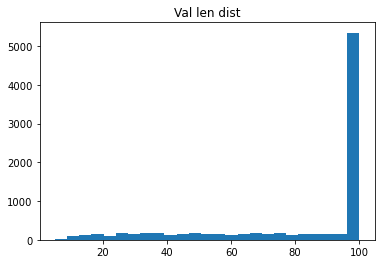

SWA score: [6.136794975537835, 6.137115898655184, 6.137554363030696]
SWA
Best score: 0.06438682657529046
Fold 2 started of 6


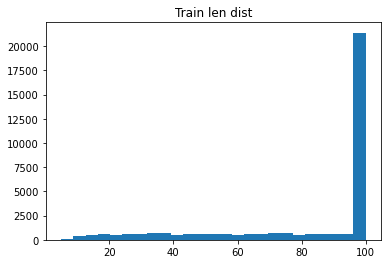

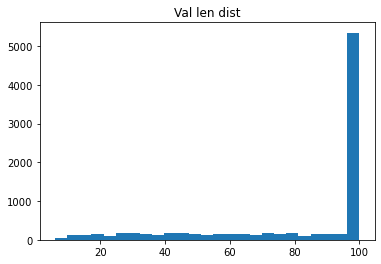

SWA score: [6.059667683355745, 6.06103217295413, 6.06118003479213]
SWA
Best score: 0.0678164858176286
Fold 3 started of 6


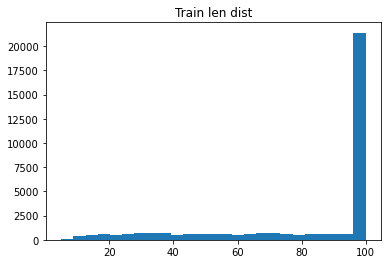

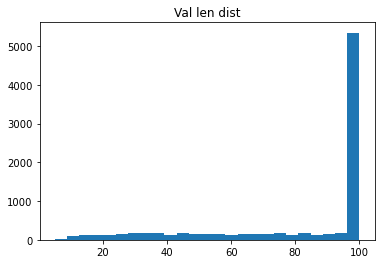

SWA score: [6.108140317676137, 6.108899409862194, 6.110077281790689]
SWA
Best score: 0.07153359984770727
Fold 4 started of 6


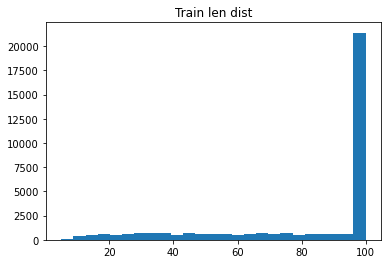

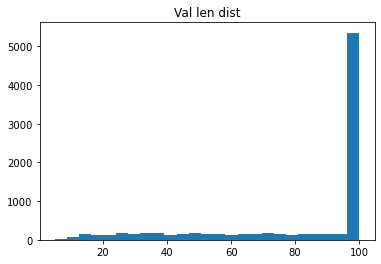

SWA score: [6.0445216321389585, 6.045089586265343, 6.045622009105652]
SWA
Best score: 0.06801728733531408
Fold 0 started of 7


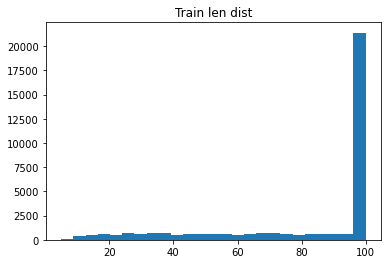

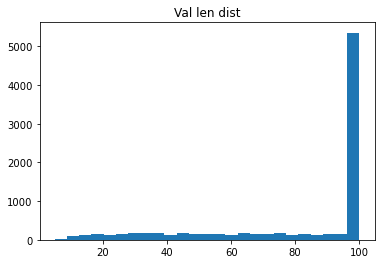

SWA score: [6.0727120909807955, 6.074092554269962, 6.074696797959673]
SWA
Best score: 0.0655126594327055
Fold 1 started of 7


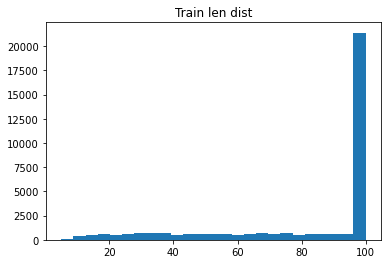

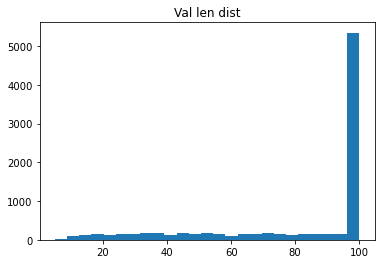

SWA score: [6.083718922722347, 6.083813796868534, 6.084018924752349]
SWA
Best score: 0.06777765086617252
Fold 2 started of 7


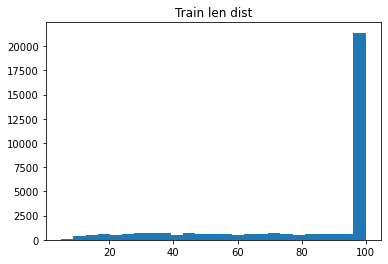

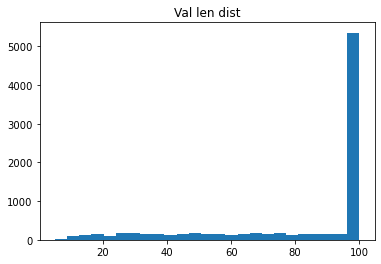

SWA score: [6.07123747993918, 6.071325403101304, 6.07187125893881]
SWA
Best score: 0.06831639063392413
Fold 3 started of 7


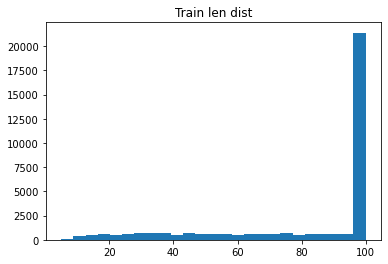

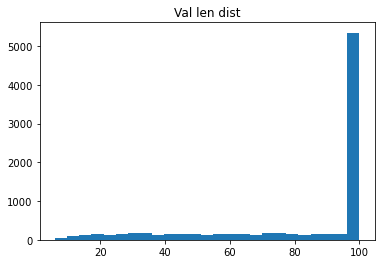

SWA score: [6.058607608015234, 6.0594405731427745, 6.05984653808402]
SWA
Best score: 0.0718572244431766
Fold 4 started of 7


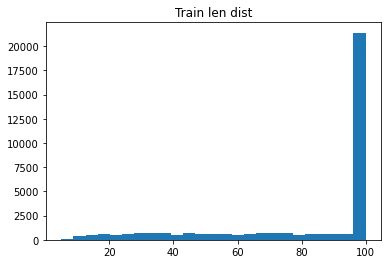

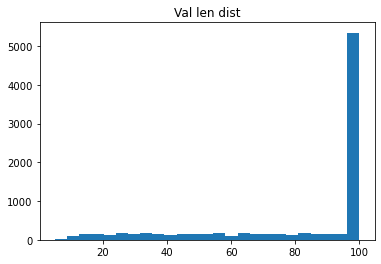

SWA score: [6.039642211751957, 6.07871028639994, 6.119711322165636]
SWA
Best score: 0.05894905186200568
Fold 0 started of 8


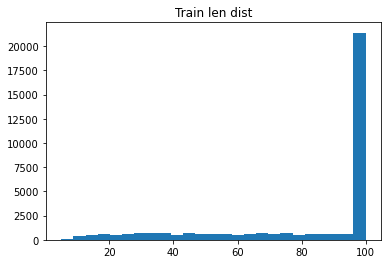

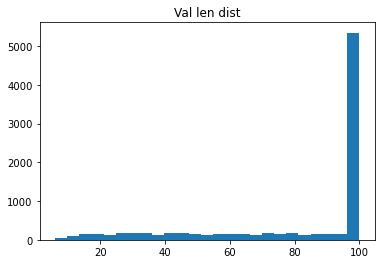

SWA score: []
SWA


RuntimeError: Please provide more then 2 checkpoints

In [22]:
all_val_targets = []
all_val_preds = []
all_test_preds = []

for semechko in [1234,1,2,3,4,5,6,7,8,9]:
    skf = StratifiedKFold(shuffle=True, random_state=semechko, n_splits=5)

    for f_id, (train_index, test_index) in enumerate(skf.split(X, lens_discrit)):
        print(f"Fold {f_id} started of {semechko}")

        train_X, train_y = X[train_index,:], y[train_index]
        val_X, val_y = X[test_index,:], y[test_index]

        train_x_lens = [(el != 0).sum() for el in train_X]
        val_x_lens = [(el != 0).sum() for el in val_X]

        plt.title('Train len dist')
        plt.hist(train_x_lens, bins=25)
        plt.show()

        plt.title('Val len dist')
        plt.hist(val_x_lens, bins=25)
        plt.show()

        '''
        train_function(
            torch.LongTensor(train_X),
            torch.LongTensor(train_y),
            torch.LongTensor(val_X),
            torch.LongTensor(val_y),
            f'../logdirs/{EXP_NAME}/fold_{f_id}_seed_{semechko}'
        )
        '''

        avarage_weights(
                path_to_chkps=glob(f'../logdirs/{EXP_NAME}/fold_{f_id}_seed_{semechko}/checkpoints/train.*_full.pth'),
                save_path=f'../logdirs/{EXP_NAME}/fold_{f_id}_seed_{semechko}/checkpoints/swa_best.pth'
            )

        val_pred = inference_function(
            torch.LongTensor(val_X),
            f'../logdirs/{EXP_NAME}/fold_{f_id}_seed_{semechko}'
        )
        val_pred = list(val_pred)
        val_target = list(val_y)
        fold_score = mean_average_precision_at_k(val_target, val_pred)
        print(f"Best score: {fold_score}")
        all_val_preds.append(val_pred)
        all_val_targets.append(val_target)

        all_test_preds.append(inference_function(
            torch.LongTensor(X_test),
            f'../logdirs/{EXP_NAME}/fold_{f_id}_seed_{semechko}',
            return_logits=True
        ))

## Compute score and create submit

In [23]:
len(all_val_targets), len(all_val_preds), len(all_test_preds)

(40, 40, 40)

In [24]:
from itertools import chain
from scipy.special import softmax

In [25]:
scores = [mean_average_precision_at_k(t,p) for t,p in zip(all_val_targets, all_val_preds)]

 Mean score : 0.06889821028213727
 STD score : 0.0027122592290286765


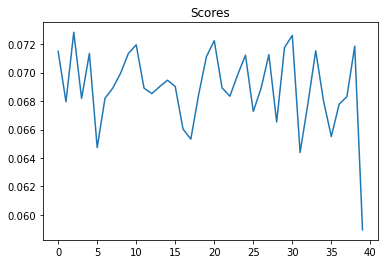

In [26]:
print(f" Mean score : {np.mean(scores)}")
print(f" STD score : {np.std(scores)}")

plt.title('Scores')
plt.plot(scores);

In [27]:
val_score = mean_average_precision_at_k(
    list(chain(*all_val_targets)), 
    list(chain(*all_val_preds))
)
print(f"OOF val score: {val_score}")

OOF val score: 0.0688982044136392


 Mean losses : 6.111182842363381
 STD losses : 0.04209812643910854


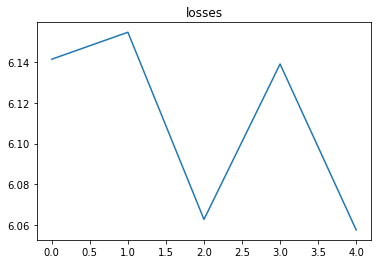

In [28]:
losses = [
    torch.load(f'../logdirs/{EXP_NAME}/fold_{idx}_seed_1234/checkpoints/best.pth', map_location='cpu')['valid_metrics']['loss']
    for idx in range(5)
]
val_loss = np.mean(losses)
print(f" Mean losses : {np.mean(losses)}")
print(f" STD losses : {np.std(losses)}")

plt.title('losses')
plt.plot(losses);

In [29]:
processed_test_preds = np.stack(all_test_preds, axis=0).mean(0)
processed_test_preds = np.argsort(-processed_test_preds)[:,:5]

In [30]:
np.save(f'../test_preds/{EXP_NAME}.npy', np.array([
    all_test_preds,test_users_in_sequences, le_film_id.classes_
]))

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [32]:
final_processed_test_preds = [le_film_id.inverse_transform(row) for row in processed_test_preds]
final_processed_test_preds = [' '.join(map(lambda x: str(x), row)) for row in final_processed_test_preds]

In [33]:
sample_submission.index = sample_submission.user_id
sample_submission.loc[test_users_in_sequences, 'movie_id'] = final_processed_test_preds

In [34]:
sample_submission

user_id                       movie_id
user_id                                                                  
16975709365084587137  16975709365084587137  17729 18165 16829 19791 17041
10225505309438393880  10225505309438393880   17079 8584 13122 13700 19851
337894458057354820      337894458057354820   16830 16996 16676 20118 1775
16389753737490268206  16389753737490268206  17909 18548 19279 17757 15392
12377183607123393787  12377183607123393787   18943 18308 15541 7347 10475
...                                    ...                            ...
16073255054457636768  16073255054457636768  16757 12497 18078 20238 18943
18217982949448186449  18217982949448186449  17239 18968 18943 17364 17756
8493046014808115881    8493046014808115881  17364 18746 18254 19383 19353
6524731807859816855    6524731807859816855   7347 17014 13378 18790 17756
17611799088817908833  17611799088817908833  12304 15489 18943 16238 18078

[1695 rows x 2 columns]

In [35]:
sample_submission.to_csv(f'../subs/{EXP_NAME}_foldseed_blend.csv', index=False)

In [36]:
results = pd.read_csv('../exp_results.csv')
results

name     score      loss
0  antonlstm_anton_seqs_2048bs_30seqlen_rmsprop_b...  0.204648  6.030000
1  antonlstm_anton_seqs_2048bs_30seqlen_adam_bylo...  0.204867  5.998311
2  antonlstm_anton_seqs_2048bs_30seqlen_adam_bylo...  0.206739  5.956410
3  biggerlstm_anton_seqs_2048bs_30seqlen_adam_byl...  0.183482  6.194156
4  biggerlstm_anton_seqs_2048bs_50seqlen_rmsprop_...  0.095208  5.895552
5  cnn_antonseqs_2048bs_100seqlen_adam_byloss_fix...  0.050939  6.152246
6  antonlsrm_antonseqs_2048bs_30seqlen_adam_bylos...  0.053155  5.940439
7  cnnbigkernel_antonseqs_2048bs_100seqlen_adam_b...  0.054607  6.130779

In [37]:
results = results.append({
    'name':EXP_NAME,
    'score':val_score,
    'loss': val_loss
}, ignore_index=True)

In [38]:
results

name     score      loss
0  antonlstm_anton_seqs_2048bs_30seqlen_rmsprop_b...  0.204648  6.030000
1  antonlstm_anton_seqs_2048bs_30seqlen_adam_bylo...  0.204867  5.998311
2  antonlstm_anton_seqs_2048bs_30seqlen_adam_bylo...  0.206739  5.956410
3  biggerlstm_anton_seqs_2048bs_30seqlen_adam_byl...  0.183482  6.194156
4  biggerlstm_anton_seqs_2048bs_50seqlen_rmsprop_...  0.095208  5.895552
5  cnn_antonseqs_2048bs_100seqlen_adam_byloss_fix...  0.050939  6.152246
6  antonlsrm_antonseqs_2048bs_30seqlen_adam_bylos...  0.053155  5.940439
7  cnnbigkernel_antonseqs_2048bs_100seqlen_adam_b...  0.054607  6.130779
8  cnnbigkernel_antonseqs_2048bs_100seqlen_adam_b...  0.068898  6.111183

In [39]:
results.to_csv('../exp_results.csv', index=False)